In [10]:
url='https://drive.google.com/file/d/18Fa0cDVGq7bf8O7KEb23CFgU0w5qsMaD/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_r = pd.read_csv(url, sep=";")
df_r

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [11]:
url='https://drive.usercontent.google.com/download?id=12xLu8LW-RvixxIPkourv73x4IUbqpYow&export=download&authuser=0&confirm=t&uuid=d43e5d1c-cec3-4518-84ae-d49b30d9c527&at=AENtkXYRTcBqWPAkd3eLSmLq1DSN%3A1733307676786'
df_a = pd.read_csv(url, sep=";")
df_a

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


Таймстэмпы оказались импортированы как целые числа, переведем их даты и переименуем колонки в привычные, простые и запоминающиеся

In [12]:
df_r.reg_ts = pd.to_datetime(df_r.reg_ts, unit='s')
df_r = df_r.rename(columns = {'reg_ts' : 'r_date',
                     'uid' : 'id'})
df_a.auth_ts = pd.to_datetime(df_a.auth_ts, unit='s')
df_a = df_a.rename(columns = {'auth_ts' : 'a_date',
                     'uid' : 'id'})

In [53]:
df_r.id.nunique() == len (df_r)

True

В регистрациях у нас только уникальные id

In [13]:
print(f' в авторизациях у нас {df_a.id.nunique()} уникальных id в {len(df_a)} авторизациях')

 в авторизациях у нас 1000000 уникальных id в 9601013 авторизациях


Все зарегистрированные id авторизовались хотя бы 1 раз

Соберем два набора данных в один по id - допишем в каждую авторизацию дату регистрации этого id.

In [14]:
df = pd.merge(df_a, df_r, how = 'left', on='id')

Посмотрим на данные

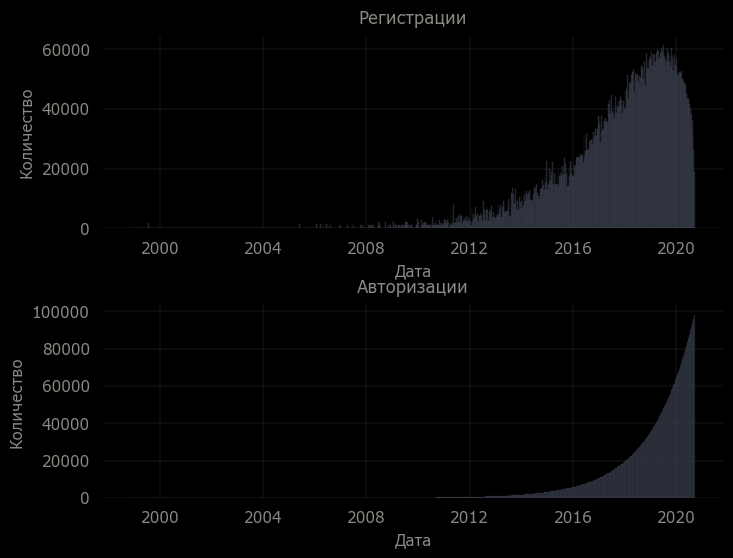

In [15]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)
plt.subplot(2, 1, 1)
sns.histplot(df.r_date, color='#171e2f')
plt.title('Регистрации', fontsize=12, y=1.02, color='#8b8a84')
plt.xlabel("Дата", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df.a_date, color='#171e2f')
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('Авторизации', fontsize=12, y=1.02,color='#8b8a84')
plt.xlabel("Дата", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)

plt.show()

Данные выглядят оборванными, а авторизации - искусственно созданными. Давайте поковыряем распределение числа авторизаций по дням

In [57]:
df_tmp = df.a_date.dt.date.value_counts().sort_index().reset_index()
df_tmp.columns = ['a_date','cnt']
df_tmp.head(1)

,a_date,cnt
0,1998-11-18,1


График авторизаций сильно похож на экспоненту, что если это она и есть?

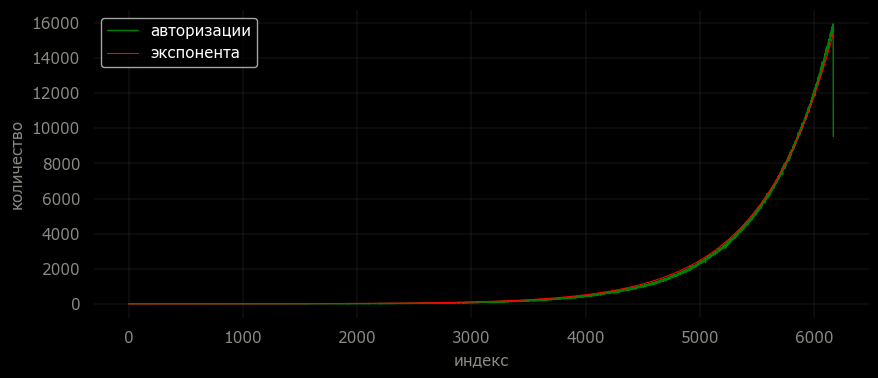

In [58]:
plt.figure(figsize=(10,4))
sns.lineplot(x = df_tmp.index, y = df_tmp.cnt, color='green',linewidth=1, label='авторизации')

tmp = pd.Series([1.001564**x for x in range(1, 6169)])

sns.lineplot(x = tmp.index, y = tmp.values, linewidth=0.8, color = ('red'), label='экспонента')
plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("индекс", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("количество", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)

plt.show()

График функции 1.001564**x поразительно совпадает с распределеним авторизаций. Что касается оборванности, то либо приложение вырубили - и с 24 сентября уже нельзя было ни авторизоваться ни зарегистрироваться, либо данные неполные, либо для этой задачи взяли или сгенерировали произвольный набор данных. Посмотрим на основные метрики набора данных.

In [59]:
df_tmp=df.groupby('id').a_date.count().sort_values(ascending = False)
print(f'\
1. Временной интервал набора данных:    начало:  {df['r_date'].min()} \n\
                                        конец:   {df['r_date'].max()} \n\
2. Уникальных пользователей:                     {df_r.id.nunique()} \n\
3. Зарегистрировались, но в игру так и не зашли: {pd.merge(df_r, df_a, how='left', on='id').a_date.isna().sum()}\n\
4. Зашли в игру один раз                         {df_tmp[df_tmp.values == 1].count()} пользователей  ({round(100*df_tmp[df_tmp.values == 1].count()/len(df_r), 1)}%) \n\
5. Зашли в игру больше одного раза:              {df_tmp[df_tmp.values > 1].count()} пользователей  ({round(100*df_tmp[df_tmp.values > 1].count()/len(df_r), 1)}%) \n\
6. NaN в наборе данных                           {df.isna().a_date.sum()+df.isna().r_date.sum()+df.isna().id.sum()} \n\
')


1. Временной интервал набора данных:    начало:  1998-11-18 09:43:43 
                                        конец:   2020-09-23 15:17:24 
2. Уникальных пользователей:                     1000000 
3. Зарегистрировались, но в игру так и не зашли: 0
4. Зашли в игру один раз                         761622 пользователей  (76.2%) 
5. Зашли в игру больше одного раза:              238378 пользователей  (23.8%) 
6. NaN в наборе данных                           0 



Проверим, совпадает ли первая авторизация с регистрацией

In [60]:
df_check = df.groupby('id', as_index = False).agg({'a_date': 'min', 'r_date': 'min'})
df_check['check'] = df_check.a_date == df_check.r_date
df_check.check.value_counts()

check
True    1000000
Name: count, dtype: int64

Совпадает для всех пользователей